In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import toeplitz

# Vector Fields with Independent Coordinates

$$
\Large f : \mathbb{R} \mapsto \mathbb{R}^2 
$$

so

$$ 
f(t) = \begin{bmatrix} f_1(t) \\ f_2(t) \end{bmatrix}
$$

is a Gaussian process with covariance: 

$$ 
Cov\left( \begin{bmatrix} f_1(x) \\ f_2(x) \end{bmatrix}, \begin{bmatrix} f_1(y) \\ f_2(y) \end{bmatrix} \right) \
                = 
                \begin{bmatrix} 
                    Cov\left(f_1(x), f_1(y)\right) & Cov\left(f_1(x), f_2(y)\right) \\ 
                    Cov\left(f_2(x), f_1(y)\right) & Cov\left(f_2(y), f_2(y)\right) 
                \end{bmatrix} 
$$

Where $Cov : \mathbb{R}\times \mathbb{R} \mapsto \mathbb{R}^{2\times 2}$.

### What is the joint distribution of $[ f(s), f(t) ]$? 
Lets assume that the joint distribution is Gaussian too. Also assume that the vector has zero mean. Then, it is entierly defined by the covariance: 

$$ K = 
\begin{bmatrix}
Cov(f(s), f(s)) & Cov(f(s), f(t)) \\
Cov(f(t), f(s)) & Cov(f(t), f(t)) 
\end{bmatrix}
$$

when: 

$$ 
\begin{bmatrix} f(s) \\ f(t) \end{bmatrix} =
\begin{bmatrix} f_1(s) \\ f_2(s) \\ f_1(t) \\ f_2(t) \end{bmatrix}
$$

In terms of the coordinates of $f$, $K$ is: 

$$ K = 
	\left[
	\begin{array}{cc|cc}
        Cov(f_1(s), f_1(s)) & Cov(f_1(s), f_2(s)) & Cov(f_1(s), f_1(t)) & Cov(f_1(s), f_2(t)) \\
        Cov(f_2(s), f_1(s)) & Cov(f_2(s), f_2(s)) & Cov(f_2(s), f_1(t)) & Cov(f_2(s), f_2(t)) \\
        \hline
        Cov(f_1(t), f_1(s)) & Cov(f_1(t), f_2(s)) & Cov(f_1(t), f_1(t)) & Cov(f_1(t), f_2(t)) \\
        Cov(f_2(t), f_1(s)) & Cov(f_2(t), f_2(s)) & Cov(f_2(t), f_1(t)) & Cov(f_2(t), f_2(t)) \\
	\end{array}
	\right]
$$

There are two types of terms in $K$:

- $Cov(f_1(s), f_2(s))$ where the covariance models the dependence between coordinates at the same input time $s$.
- $Cov(f_1(s), f_2(t))$ that models the dependence between coordinates at different inputs $s$ and $t$.

It is possible to assume, for example, that the coordinates are independent. In that case it is convenient to rearange the vector as:

$$ \begin{bmatrix} f_1(s) \\ f_1(t) \\ f_2(s) \\ f_2(t) \end{bmatrix} $$

so that the covariance matrix becomes block-diagonal: 

$$ K = 
	\left[
	\begin{array}{cc|cc}
        Cov(f_1(s), f_1(s)) & Cov(f_1(s), f_1(t)) & 0 & 0 \\
        Cov(f_1(t), f_1(s)) & Cov(f_1(t), f_1(t)) & 0 & 0\\
        \hline
        0 & 0 & Cov(f_2(s), f_2(s)) & Cov(f_2(s), f_2(t)) \\
        0 & 0 & Cov(f_2(t), f_2(s)) & Cov(f_2(t), f_2(t)) \\
	\end{array}
	\right]
$$

Each diagonal block models the covariance structure for each coordinate over time. 

The off diagonal terms - which are $0$ here - model the dependence between coordinates. 

In [2]:
k1 = GPy.kern.RBF(input_dim=1,lengthscale=0.2)
k2 = GPy.kern.Matern32(1, 0.5, 0.2)

nt = 50 
m = 20 

t = np.linspace(0.,1.,nt)
t = t[:,None]

mu = np.zeros((nt+nt))

C1 = k1.K(t,t)
C2 = k2.K(t,t)

C = np.kron([[1,0],[0,0]], C1) + np.kron([[0,0],[0,1]], C2)

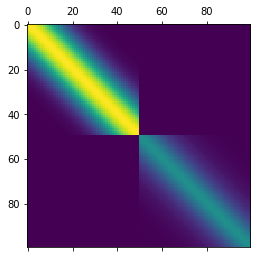

In [3]:
plt.matshow(C)
plt.show()

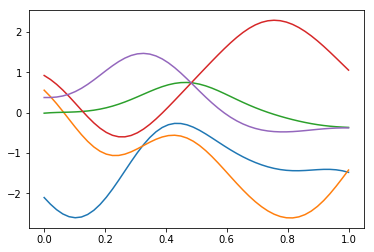

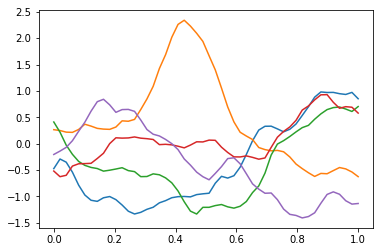

In [4]:
np.random.seed(0)

Z = np.random.multivariate_normal(mu,C,m)
Z = Z.T
plt.figure(1) # open new plotting window
for i in range(5):
    plt.plot(t,Z[0:nt,i])
plt.show()

plt.figure(2) # open new plotting window
for i in range(5):
    plt.plot(t,Z[nt:nt+nt,i])
plt.show()

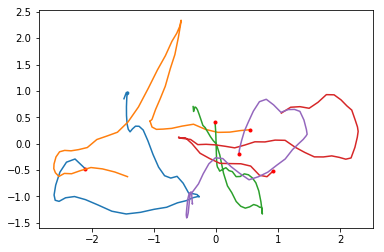

In [5]:
for i in range(5):
        
    a = Z[0:nt, i]
    b = Z[nt:nt+nt, i]

    plt.plot(a, b)
    plt.plot(a[0], b[0], 'r.')

plt.show()

# $\mathbb{R}^2 \rightarrow \mathbb{R}^2$ Process

with independent coordinates

In [6]:
d = 2
nxGrid = 6

x = np.linspace(0., 1., nxGrid)
y = np.linspace(0., 1., nxGrid)

L = []
for i in range(nxGrid):
    for j in range(nxGrid):
        L.append([x[i], y[j]])

X = np.reshape(L, (nxGrid*nxGrid, d))

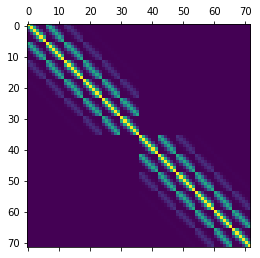

In [7]:
k = GPy.kern.RBF(input_dim=2, lengthscale=0.2)

S = k.K(X, X)
Sigma = np.kron([[1,0],[0,1]], S)

plt.matshow(Sigma)
plt.show()

In [8]:
np.random.seed(0)

mu = np.zeros(d*nxGrid*nxGrid)
Z = np.random.multivariate_normal(mu, Sigma, 2)

In [9]:
dx0 = Z[0][0:nxGrid*nxGrid]
dy0 = Z[0][nxGrid*nxGrid:d*nxGrid*nxGrid]

dx1 = Z[1][0:nxGrid*nxGrid]
dy1 = Z[1][nxGrid*nxGrid:d*nxGrid*nxGrid]

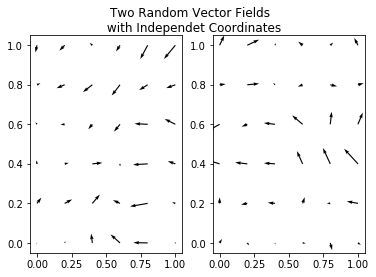

In [10]:
# https://stackoverflow.com/questions/25342072/computing-and-drawing-vector-fields
xx, yy = np.meshgrid(x, x)


fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.quiver(xx, yy, dx0, dy0)
ax1.quiver(xx, yy, dx1, dy1)

plt.suptitle('Two Random Vector Fields \n with Independet Coordinates')
plt.show()

# $\mathbb{R}^2 \rightarrow \mathbb{R}^2$ Process

with dependent coordinates


$$ 
f(x) = 
\begin{bmatrix}
f_1(x) \\
f_2(x)
\end{bmatrix}
$$

where $f_1(x) = a_1 u(x)$, $f_2(x) = a_2 u(x)$ and $u(x) \sim \mathcal{GP}\left(0, k(x, x)\right)$.

The covariance matrix of $f(x)$ is:

$$ 
K = 
    \begin{bmatrix}
    a_1^2 Cov(u(x), u(x)) & a_1 a_2 Cov(u(x), u(x)) \\
    a_2 a_1 Cov(u(x), u(x)) & a_2^2 Cov(u(x), u(x)) \\
    \end{bmatrix}
  = k(x, x) \left( \begin{bmatrix} a_1 \\ a_2\end{bmatrix} \begin{bmatrix} a_1 & a_2 \end{bmatrix} \right) = k(x, x) aa^T
$$

So the covariance matrix over n inputs $x_1, ... , x_n$ is:

$$ 
\begin{bmatrix} 
k(x_1, x_1) a a^T & \cdots & k(x_1, x_n)  a a^T\\
\vdots & \ddots & \vdots \\
k(x_n, x_1) a a^T & \cdots & k(x_n, x_n)  a a^T
\end{bmatrix} 
 =:
\begin{bmatrix} 
k(x_1, x_1) & \cdots & k(x_1, x_n) \\
\vdots & \ddots & \vdots \\
k(x_n, x_1) & \cdots & k(x_n, x_n)
\end{bmatrix} \otimes a a^T
$$

In [11]:
d = 2
nxGrid = 6

x = np.linspace(0., 1., nxGrid)
y = np.linspace(0., 1., nxGrid)

L = []
for i in range(nxGrid):
    for j in range(nxGrid):
        L.append([x[i], y[j]])

X = np.reshape(L, (nxGrid*nxGrid, d))

In [12]:
k = GPy.kern.RBF(input_dim=2, lengthscale=0.2)
Sigma = k.K(X, X)

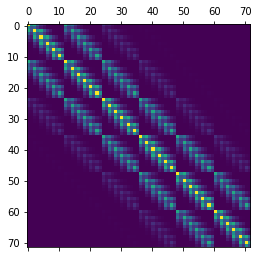

(72, 72)

In [13]:
a1 = 2
a2 = 1

a = np.array([[a1], [a2]])

K = np.kron(Sigma, a.dot(a.T))

plt.matshow(K)
plt.show()

K.shape

# np.kron(np.eye(2), a.dot(a.T))

In [14]:
np.random.seed(0)

mu = np.zeros(d*nxGrid*nxGrid)
Z = np.random.multivariate_normal(mu, K, 2)

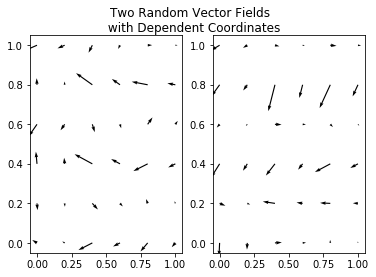

In [15]:
dx0 = Z[0][0:nxGrid*nxGrid]
dy0 = Z[0][nxGrid*nxGrid:d*nxGrid*nxGrid]

dx1 = Z[1][0:nxGrid*nxGrid]
dy1 = Z[1][nxGrid*nxGrid:d*nxGrid*nxGrid]

xx, yy = np.meshgrid(x, x)


fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.quiver(xx, yy, dx0, dy0)
ax1.quiver(xx, yy, dx1, dy1)

plt.suptitle('Two Random Vector Fields \n with Dependent Coordinates')
plt.show()

## $\nabla \cdot F = 0$ (In progress) 

$$ \Large
k_{div}(x, y) = 
\begin{bmatrix}
\partial_{y_2 y_2} & -\partial_{x_2 y_1} \\
-\partial_{x_1 y_2} & \partial_{x_1 x_1} \\
\end{bmatrix}
k(x, y)
$$

with $x = [x_1, x_2]$ and $y = [y_1, y_2]\in \mathbb{R}^2$.

For the squared exponential kernel: 


$$ 
\partial_{x_1 x_1} k(x, y) = \left( \dfrac{(x_1 - y_1)^2}{l^2} - \dfrac{1}{l} \right) e^{-\dfrac{(x - y)^2}{2l}} 
$$

for tthe same coordinate and

$$ 
\partial_{x_1 y_2} k(x, y) =  \left( \dfrac{(x_1 - y_1)}{l}\dfrac{(x_2 - y_2)}{l} \right)  e^{-\dfrac{(x - y)^2}{2l}} 
$$

for coordinates of different vectors. 

The matrix is 

$$ 
K_{div}(x, y) = 
\begin{bmatrix}
\left( \dfrac{(x_2 - y_2)^2}{l^2} - \dfrac{1}{l} \right) & - \left( \dfrac{(x_2 - y_2)}{l}\dfrac{(x_1 - y_1)}{l} \right) \\
- \left( \dfrac{(x_1 - y_1)}{l}\dfrac{(x_2 - y_2)}{l} \right) & \left( \dfrac{(x_1 - y_1)^2}{l^2} - \dfrac{1}{l} \right) \\
\end{bmatrix}
e^{-\dfrac{(x - y)^2}{2l}} 
$$

$$
K_{div}(x, y) = \left(
\begin{bmatrix}
\left( \dfrac{(x_2 - y_2)^2}{l^2} \right) & - \left( \dfrac{(x_2 - y_2)}{l}\dfrac{(x_1 - y_1)}{l} \right) \\
- \left( \dfrac{(x_1 - y_1)}{l}\dfrac{(x_2 - y_2)}{l} \right) & \left( \dfrac{(x_1 - y_1)^2}{l^2} \right) \\
\end{bmatrix}
- \dfrac{1}{l}
\begin{bmatrix}
 1 & 0 \\
0 &  1
\end{bmatrix} \right) e^{-\dfrac{(x - y)^2}{2l}} 
$$

$$
K_{div}(x, y) = \left( (dd^T)_T \times_e \begin{bmatrix} 1 & -1 \\ -1 & 1 \end{bmatrix}- \dfrac{1}{l} I_2 \right)
e^{-\dfrac{(x - y)^2}{2l}}
$$

Where $\times_e$ is the elementwise multiplication and

$$ 
(dd^T)_T = \left( \dfrac{(x - y)}{l}\dfrac{(x - y)}{l}^T \right)_T
$$

and $(A)_T$ is the transpose with respect to the anti-diagonal. 

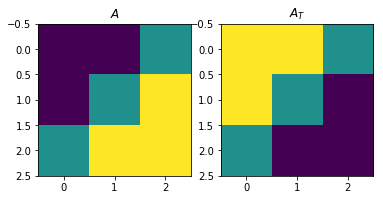

In [16]:
A = np.array([[10, 10, 20], [10, 20, 30], [20, 30, 30]])
A_T = np.rot90(A,2).T

plt.subplot(1, 2, 1)
plt.imshow(A)
plt.title('$A$')
plt.subplot(1, 2, 2)
plt.imshow(A_T)
plt.title('$A_T$')
plt.show()

In [17]:
def divFreeKern(x, y):
    '''
    input: 
        - x and y two row vectors in R^n.
    output: 
        - k(x, y) div free kernel R^nxn matrix.
    '''
    
    n = len(x)
    d = x - y
    normd = np.sum(d**2/2)
    T1 = np.e**normd
    
    In = np.eye(n, n)
    v = np.reshape(d, (n, 1))
    vt = np.transpose(v)
    ddT = v.dot(vt)
    
    nod = np.repeat(1, n)
    nod[1:n] = -1
    NOD = toeplitz(nod)
    
    T2 = NOD*np.rot90(ddT,2).T - In 
    
    return(T1*T2)

In [18]:
X = np.array([[-0.5, 0.5], [0.5, -0.5]])
X[0]

#d = 2
#nxGrid = 3

#x = np.linspace(0., 1., nxGrid)
#y = np.linspace(0., 1., nxGrid)

#L = []
#for i in range(nxGrid):
#    for j in range(nxGrid):
#        L.append([x[i], y[j]])

#X = np.reshape(L, (nxGrid*nxGrid, d))

array([-0.5,  0.5])

In [19]:
print(divFreeKern(X[0], X[1]), '\n', divFreeKern(X[1], X[0]))

[[0.         2.71828183]
 [2.71828183 0.        ]] 
 [[0.         2.71828183]
 [2.71828183 0.        ]]


In [20]:
npoints = X.shape[0]

K = {}

for i in range(npoints):
    for j in range(npoints):
        dicIndex = str(i) + str(j)  
        K[dicIndex] = divFreeKern(X[i], X[j])
        

In [21]:
len(K)

4

In [22]:
K

{'00': array([[-1., -0.],
        [-0., -1.]]), '01': array([[0.        , 2.71828183],
        [2.71828183, 0.        ]]), '10': array([[0.        , 2.71828183],
        [2.71828183, 0.        ]]), '11': array([[-1., -0.],
        [-0., -1.]])}

In [23]:
# use a different arrangement on the vector of observations [x, y, z] instead of coordiante wise order. 
# In that sense the cov mat is [[Kxx, Kxy, Kxz], [Kyx, Kyy, Kyz], [Kzx, Kzy, Kzz]]

divFreeK = np.zeros((2*npoints, 2*npoints))
# np.diag([1, 2, 3, 4])

In [26]:
i = 0
j = 0

for i in range(2, 2*npoints+1, 2):
    for j in range(2, 2*npoints+1, 2):
        SM = np.ix_(np.arange(0, i), np.arange(0, j))
        divFreeK[SM] = K[chr(i)+chr(j)]
        i = i + 1

In [28]:
SM = np.ix_(np.arange(0, 2), np.arange(0, 2))
SM[1]

array([[0, 1]])

In [25]:
divFreeK

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [43]:
divFreeK = np.zeros((2*npoints, 2*npoints))

for k in K:
    i = int(list(k)[0])
    j = int(list(k)[1])
    
    iSM = np.where( (np.arange(1, 2*npoints + 1) % npoints) == ( (i + 1) % npoints))[0]
    jSM = np.where( (np.arange(1, 2*npoints + 1) % npoints) == ( (j + 1) % npoints))[0]
    # print(i, iSM, '\n', j, jSM)

    SM = np.ix_(iSM, jSM)
    divFreeK[SM] = K[k]

In [44]:
divFreeK.shape

(4, 4)

In [45]:
K['00']

array([[-1., -0.],
       [-0., -1.]])

In [46]:
np.linalg.eig(divFreeK)

(array([ 1.71828183, -3.71828183,  1.71828183, -3.71828183]),
 array([[ 0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.70710678, -0.70710678],
        [ 0.        ,  0.        ,  0.70710678,  0.70710678],
        [ 0.70710678, -0.70710678,  0.        ,  0.        ]]))

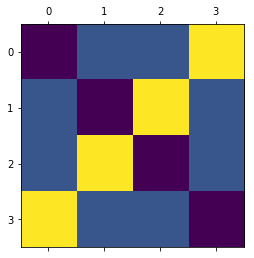

In [187]:
plt.matshow(divFreeK)
plt.show()

In [188]:
np.random.seed(0)

mu = np.zeros(2*npoints)
Z = np.random.multivariate_normal(mu, divFreeK, 2)

 C:\Users\Personal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:covariance is not positive-semidefinite.


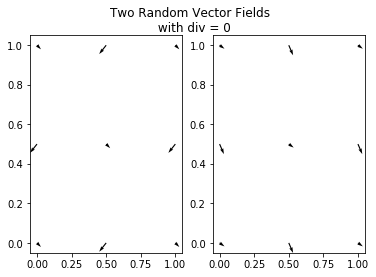

In [189]:
dx0 = Z[0][0:npoints]
dy0 = Z[0][npoints:2*npoints]

dx1 = Z[1][0:npoints]
dy1 = Z[1][npoints:2*npoints]

xx, yy = np.meshgrid(x, x)

fig, (ax0, ax1) = plt.subplots(1, 2)

ax0.quiver(xx, yy, dx0, dy0)
ax1.quiver(xx, yy, dx1, dy1)

plt.suptitle('Two Random Vector Fields \n with div = 0')
plt.show()

## $\nabla \times F = 0$ (In progress) 

$$
K_{curl}(x, x') = \underbrace{ \dfrac{\sigma_f^2}{l^2} e^{-\dfrac{\|x - x'\|^2}{2l^2}} }_{T_1}
    \underbrace{ \left( I_n - \left(\dfrac{x - x'}{l} \right) \left( \dfrac{x - x'}{l} \right)^t \right)}_{T_2}
$$

with $x \in \mathbb{R}^n$.

In [ ]:
def curlFreeKern(x, y):
    '''
    input: 
        - x and y two row vectors in R^n.
    output: 
        - k(x, y) div free kernel R^nxn matrix.
    '''
    
    n = len(x)
    d = x - y
    normd = np.sum(d**2/2)
    T1 = np.e**normd
    
    In = np.eye(n, n)
    v = np.reshape(d, (n, 1))
    vt = np.transpose(v)
    T2 = In - v.dot(vt)
    
    return(T1*T2)

# Symbolic Derivation (In progress)

In [22]:
# http://docs.sympy.org/latest/tutorial/preliminaries.html
# see the derivatives notebook too, in sage. 
import sympy 